In [1]:
%load_ext autoreload
%autoreload 2

%load_ext watermark

import os
from io import StringIO

import numpy as np
import pandas as pd
import requests
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from tqdm import tqdm

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [61]:
DATA_LOCATION = '/mnt/data/d.kornilov/TCGA/processed_mtcp_intersection_all/GBM_LGG'
LABELS = 'labels_mtcp_intersection_all_GBM,LGG.tsv'
BASE_DIR_mRNA = '/mnt/data/d.kornilov/TCGA/raw/RNA-seq_STAR' #'/mnt/data/m.zubrikhina/TCGA/GBMLGG/raw_RNA' # '/mnt/data/d.kornilov/TCGA/raw/RNA-seq_FPKM-UQ' #'/mnt/dataA/TCGA/raw/RNA-seq_FPKM-UQ/'
MTCP_CLINICAL_DATA_LOCATION = '/home/d.kornilov/work/multisurv/data/dataset_inetrsection_all.csv' #'../../mtcp/src/data/dataset.csv'
mRNA_VARIANCE_FILE = "/mnt/data/d.kornilov/TCGA/raw/RNA-seq_STAR_variance_mtcp_intersection_all_split.tsv" # '/mnt/data/m.zubrikhina/TCGA/GBMLGG/raw_RNA_variance_mtcp_split.tsv'

In [3]:
pd.read_csv(MTCP_CLINICAL_DATA_LOCATION).count()

submitter_id                                      4784
tumor_stage                                       3664
age_at_diagnosis                                  4730
prior_treatment                                   4781
prior_malignancy                                  4693
synchronous_malignancy                            4343
days_to_last_follow_up                            3317
gender                                            4784
race                                              4468
vital_status                                      4784
days_to_death                                     1467
treatments_pharmaceutical_treatment_or_therapy    4272
treatments_radiation_treatment_or_therapy         4297
project_id                                        4784
time                                              4784
event                                             4784
RNA                                               4784
DNAm                                              4741
MRI       

In [4]:
!ls '{BASE_DIR_mRNA}/0007888f-8d96-4c01-8251-7fef6cc71596'

88215dd0-5841-44f1-9393-eefd8238cbb3.rna_seq.augmented_star_gene_counts.tsv
logs


In [5]:
pd.read_csv(MTCP_CLINICAL_DATA_LOCATION)['RNA'][0]

'/data/TCGA/raw/RNA/0be0d83b-9baa-4898-967c-81c466e8fb78/edd5bf74-7675-4c67-9863-2369b2f72bfa.rna_seq.augmented_star_gene_counts.csv'

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#miRNA" data-toc-modified-id="miRNA-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>miRNA</a></span><ul class="toc-item"><li><span><a href="#Map-files-to-patients" data-toc-modified-id="Map-files-to-patients-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Map files to patients</a></span><ul class="toc-item"><li><span><a href="#Drop-unused-patients" data-toc-modified-id="Drop-unused-patients-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Drop unused patients</a></span></li></ul></li><li><span><a href="#Load-all-data" data-toc-modified-id="Load-all-data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Load all data</a></span></li><li><span><a href="#Scale-values" data-toc-modified-id="Scale-values-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Scale values</a></span></li><li><span><a href="#Save-to-files" data-toc-modified-id="Save-to-files-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Save to files</a></span></li></ul></li><li><span><a href="#mRNA" data-toc-modified-id="mRNA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>mRNA</a></span><ul class="toc-item"><li><span><a href="#Map-files-to-patients" data-toc-modified-id="Map-files-to-patients-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Map files to patients</a></span><ul class="toc-item"><li><span><a href="#Drop-unused-patients" data-toc-modified-id="Drop-unused-patients-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Drop unused patients</a></span></li></ul></li><li><span><a href="#Pick-gene-subset" data-toc-modified-id="Pick-gene-subset-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Pick gene subset</a></span><ul class="toc-item"><li><span><a href="#Compute-variance-for-all-genes" data-toc-modified-id="Compute-variance-for-all-genes-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Compute variance for all genes</a></span></li><li><span><a href="#Define-gene-subset" data-toc-modified-id="Define-gene-subset-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Define gene subset</a></span></li></ul></li><li><span><a href="#Load-all-data" data-toc-modified-id="Load-all-data-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Load all data</a></span></li><li><span><a href="#Scale-values" data-toc-modified-id="Scale-values-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Scale values</a></span></li><li><span><a href="#Save-to-files" data-toc-modified-id="Save-to-files-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Save to files</a></span></li></ul></li><li><span><a href="#DNA-methylation" data-toc-modified-id="DNA-methylation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>DNA methylation</a></span><ul class="toc-item"><li><span><a href="#Map-files-to-patients" data-toc-modified-id="Map-files-to-patients-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Map files to patients</a></span><ul class="toc-item"><li><span><a href="#Drop-unused-patients" data-toc-modified-id="Drop-unused-patients-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Drop unused patients</a></span></li></ul></li><li><span><a href="#Pick-probe-subset" data-toc-modified-id="Pick-probe-subset-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Pick probe subset</a></span><ul class="toc-item"><li><span><a href="#Save-to-file" data-toc-modified-id="Save-to-file-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Save to file</a></span></li><li><span><a href="#Compute-variance-for-all-selected-probes" data-toc-modified-id="Compute-variance-for-all-selected-probes-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Compute variance for all selected probes</a></span></li><li><span><a href="#Define-probe-subset" data-toc-modified-id="Define-probe-subset-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Define probe subset</a></span></li></ul></li><li><span><a href="#Load-all-data" data-toc-modified-id="Load-all-data-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Load all data</a></span></li><li><span><a href="#Replace-nan-by-median-value" data-toc-modified-id="Replace-nan-by-median-value-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Replace <code>nan</code> by median value</a></span></li><li><span><a href="#Save-to-files" data-toc-modified-id="Save-to-files-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Save to files</a></span></li></ul></li><li><span><a href="#CNV" data-toc-modified-id="CNV-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>CNV</a></span><ul class="toc-item"><li><span><a href="#Map-aliquotes-to-patients" data-toc-modified-id="Map-aliquotes-to-patients-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Map aliquotes to patients</a></span></li><li><span><a href="#Load-all-data" data-toc-modified-id="Load-all-data-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Load all data</a></span></li><li><span><a href="#Are-there-unchanged-genes?" data-toc-modified-id="Are-there-unchanged-genes?-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Are there unchanged genes?</a></span></li><li><span><a href="#Replace-aliquote-by-patient-IDs" data-toc-modified-id="Replace-aliquote-by-patient-IDs-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Replace aliquote by patient IDs</a></span><ul class="toc-item"><li><span><a href="#Check-duplicate-patient-IDs" data-toc-modified-id="Check-duplicate-patient-IDs-4.4.1"><span class="toc-item-num">4.4.1&nbsp;&nbsp;</span>Check duplicate patient IDs</a></span></li></ul></li><li><span><a href="#Encode-categorical-variables" data-toc-modified-id="Encode-categorical-variables-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Encode categorical variables</a></span><ul class="toc-item"><li><span><a href="#Drop-unused-patients" data-toc-modified-id="Drop-unused-patients-4.5.1"><span class="toc-item-num">4.5.1&nbsp;&nbsp;</span>Drop unused patients</a></span></li></ul></li><li><span><a href="#Keep-only-high-variance-genes" data-toc-modified-id="Keep-only-high-variance-genes-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Keep only high-variance genes</a></span></li><li><span><a href="#Save-to-files" data-toc-modified-id="Save-to-files-4.7"><span class="toc-item-num">4.7&nbsp;&nbsp;</span>Save to files</a></span></li></ul></li></ul></div>

# Functions <a class='tocSkip'></a>

In [6]:
def request_file_info(data_type):
    fields = [
        'file_name',
        'cases.submitter_id',
        'cases.samples.sample_type',
        'cases.project.project_id',
        'cases.project.primary_site',
        ]

    fields = ','.join(fields)

    files_endpt = 'https://api.gdc.cancer.gov/files'

    filters = {
        'op': 'and',
        'content':[
            {
            'op': 'in',
            'content':{
                'field': 'files.experimental_strategy',
                'value': [data_type]
                }
            }
        ]
    }

    params = {
        'filters': filters,
        'fields': fields,
        'format': 'TSV',
        'size': '400000'
        }

    response = requests.post(files_endpt, headers = {'Content-Type': 'application/json'}, json = params)

    return pd.read_csv(StringIO(response.content.decode('utf-8')), sep='\t')

In [7]:
def make_patient_file_map(df, base_dir):
    d = {}
    
    for _, row in df.iterrows():
        patient = row['cases.0.submitter_id']
        if patient in d:
            if not isinstance(d[patient], tuple):
                d[patient] = (
                    d[patient],
                    os.path.join(base_dir, row.id, row.file_name))
            else:
                d[patient] += os.path.join(base_dir, row.id, row.file_name),
        else:
            d[patient] = os.path.join(base_dir, row.id, row.file_name)

    return d

In [8]:
def min_max_scale(data, features, groups):
    train = data.loc[data.index.isin(groups['train']), features]

    scaler = MinMaxScaler()
    columns = train.columns
    scaler = scaler.fit(train[columns])
    
    data.loc[data.index.isin(groups['train']), features] = scaler.transform(
        train)
    # data.loc[data.index.isin(groups['val']), features] = scaler.transform(
    #     data.loc[data.index.isin(groups['val']), features])
    data.loc[data.index.isin(groups['test']), features] = scaler.transform(
        data.loc[data.index.isin(groups['test']), features])
    
    return data

In [9]:
def table_to_patient_files(table, dir_path, round_digits=4):
    n = len(table)
    
    i = 0

    for index, row in table.iterrows():
        print('\r' + f'Save data to files: {str(i + 1)}/{n}', end='')
        i+= 1

        target_file = os.path.join(dir_path, str(index) + '.tsv')
        
        with open(target_file, 'w') as f:
            if round_digits is not None:
                f.write('\n'.join(str(round(value, round_digits)) for value in row.values))
            else:
                f.write('\n'.join(str(value) for value in row.values))

    print()
    print()

In [10]:
def merge_all_tables(table_list):
    n = len(table_list)
    
    final_table = pd.DataFrame()

    for i, table in enumerate(table_list):
        print('\r' + f'Merge data tables: {str(i + 1)}/{n}', end='')

        if final_table.empty:
            final_table = table
        else:
            final_table = final_table.join(table)
    
    print()
    print('Final table dimensions:', final_table.shape)
    print()

    return final_table

In [11]:
labels = pd.read_csv(LABELS, sep='\t')
labels.head()

,submitter_id,project_id,time,event,group,splits
0,TCGA-CS-4938,LGG,9.791781,0,train,0.0
1,TCGA-CS-4941,LGG,0.641096,1,train,4.0
2,TCGA-CS-4942,LGG,3.657534,1,train,2.0
3,TCGA-CS-4943,LGG,3.030137,1,train,3.0
4,TCGA-CS-4944,LGG,5.008219,0,train,3.0


In [12]:
labels.shape

(568, 6)

In [13]:
id_groups = {
    'train': list(labels.loc[labels['group'] == 'train', 'submitter_id']),
    # 'val': list(labels.loc[labels['group'] == 'val', 'submitter_id']),
    'test': list(labels.loc[labels['group'] == 'test', 'submitter_id'])}

# miRNA

## Map files to patients

Use the [GDC API](https://docs.gdc.cancer.gov/API/Users_Guide/Python_Examples/#using-python-to-query-the-gdc-api) to retrieve mapping between file names and patient IDs. Collect results as Pandas `DataFrame`.

In [3]:
%%time

miRNA_files = request_file_info(data_type='miRNA-Seq')
miRNA_files.shape

CPU times: user 278 ms, sys: 58.9 ms, total: 337 ms
Wall time: 20.2 s


(43524, 10)

In [22]:
miRNA_files.head()

NameError: name 'miRNA_files' is not defined

In [5]:
miRNA_files = miRNA_files[miRNA_files['cases.0.project.project_id'].str.startswith('TCGA')]
miRNA_files = miRNA_files[miRNA_files['file_name'].str.endswith('mirbase21.mirnas.quantification.txt')]
miRNA_files = miRNA_files[miRNA_files['cases.0.samples.0.sample_type'] == 'Primary Tumor']
miRNA_files.shape

(9786, 10)

Some cases have more than one `*mirbase21.mirnas.quantification.txt` file. I suppose these are replicate runs for the same patient. Accordingly, checking some examples showed that `reads_per_million_miRNA_mapped` values were highly correlated. Here I will simply keep the first one in the table and drop the other ones. This decision may be revisited later on if deemed useful.

In [6]:
print('All rows:       ', miRNA_files.shape[0])
print('Unique patients:', miRNA_files['cases.0.submitter_id'].unique().shape[0])

All rows:        9786
Unique patients: 9691


In [7]:
miRNA_files = miRNA_files[~miRNA_files.duplicated(subset=['cases.0.submitter_id'], keep='first')]
miRNA_files.shape

(9691, 10)

In [12]:
file_map = make_patient_file_map(df=miRNA_files, base_dir='/mnt/dataA/TCGA/raw/miRNA-seq/')

### Drop unused patients

Keep only patients present in label data.

In [13]:
len(file_map)

9691

In [14]:
labels = pd.read_csv('../data/labels.tsv', sep='\t')
len(labels['submitter_id'])

11081

In [15]:
file_map = {k: file_map[k] for k in file_map if k in list(labels['submitter_id'])}

In [16]:
len(file_map)

9616

## Load all data

In [17]:
def load_all_miRNA_data(patient_file_map):
    n = len(patient_file_map)
    
    dfs = []
    for i, patient in enumerate(patient_file_map):
        print('\r' + f'Load data tables: {str(i + 1)}/{n}', end='')
        df = pd.read_csv(patient_file_map[patient], sep='\t',
                         usecols=['miRNA_ID', 'reads_per_million_miRNA_mapped'],
                         index_col=0)
        df.columns = [patient]
        dfs.append(df)

    print()
    print()

    return dfs

In [18]:
%%time

data_tables = load_all_miRNA_data(patient_file_map=file_map)

Load data tables: 9616/9616

CPU times: user 58.3 s, sys: 2.92 s, total: 1min 1s
Wall time: 2min 15s


In [21]:
%%time

miRNA = merge_all_tables(data_tables)

Merge data tables: 9616/9616
Final table dimensions: (1881, 9616)

CPU times: user 14min 16s, sys: 2.21 s, total: 14min 18s
Wall time: 14min 16s


## Scale values

In [22]:
miRNA.shape

(1881, 9616)

In [23]:
miRNA.head()

,TCGA-E7-A7PW,TCGA-29-1710,TCGA-51-4080,TCGA-FY-A4B3,TCGA-DO-A1K0,TCGA-L6-A4EU,TCGA-A2-A0CW,TCGA-SN-A84X,TCGA-18-3412,TCGA-52-7810,...,TCGA-2H-A9GN,TCGA-AA-3984,TCGA-A6-2674,TCGA-D5-6537,TCGA-XV-A9VZ,TCGA-DR-A0ZL,TCGA-MA-AA42,TCGA-B9-4116,TCGA-EM-A2P3,TCGA-EL-A3T7
miRNA_ID,,,,,,,,,,,,,,,,,,,,,
hsa-let-7a-1,7702.242665,35231.700503,4489.288728,7287.179599,13938.523841,8068.154342,8205.384637,6971.318119,5961.129234,10476.293078,...,22716.940490,2920.563932,3552.978172,4726.711379,49596.634890,8989.747445,20294.423267,6945.405056,12240.356017,38696.506747
hsa-let-7a-2,7616.658261,35092.734455,4459.787397,7255.432402,13923.011786,8056.829972,8194.911163,6964.759965,5914.691572,10509.742151,...,22744.904718,2861.431320,3630.118183,4726.379471,49438.492357,8929.129343,20194.679988,6978.499662,12288.175443,38638.477401
hsa-let-7a-3,7736.547157,35478.222466,4484.710935,7226.230971,13908.224593,8013.062814,8230.807427,6958.118796,6092.295259,10746.274881,...,23021.351088,2869.818924,3571.885037,4799.399378,49600.410561,8981.028403,20224.825241,6944.661357,12217.508959,38740.935465
hsa-let-7b,9805.779989,117794.983199,8493.840071,6525.546385,4572.286974,4444.815122,9055.526328,8089.441936,15600.610044,39026.162822,...,10039.956887,7023.780117,15789.501547,6533.290274,113964.421270,25519.182619,18972.199687,7817.392145,11921.736957,7503.013106
hsa-let-7c,189.912499,8082.874529,285.857723,2520.907101,4955.594205,1874.030160,1434.776354,10982.086111,693.306133,1454.817470,...,720.278620,202.560652,549.055375,279.467101,13509.932121,3152.348858,5704.259788,162.870083,5323.718913,5003.217682


In [61]:
miRNA = min_max_scale(data=miRNA.T, features=miRNA.T.columns, groups=id_groups)

NameError: name 'miRNA' is not defined

In [37]:
miRNA.head()

miRNA_ID,hsa-let-7a-1,hsa-let-7a-2,hsa-let-7a-3,hsa-let-7b,hsa-let-7c,hsa-let-7d,hsa-let-7e,hsa-let-7f-1,hsa-let-7f-2,hsa-let-7g,...,hsa-mir-941-5,hsa-mir-942,hsa-mir-943,hsa-mir-944,hsa-mir-95,hsa-mir-9500,hsa-mir-96,hsa-mir-98,hsa-mir-99a,hsa-mir-99b
TCGA-E7-A7PW,0.098265,0.097915,0.098351,0.026496,0.001666,0.015145,0.103723,0.080515,0.081527,0.236945,...,0.0,0.025166,0.000000,0.083800,0.021908,0.0,0.120594,0.219193,0.003812,0.072224
TCGA-29-1710,0.481244,0.481941,0.484883,0.331422,0.078067,0.103172,0.164462,0.013440,0.013666,0.023227,...,0.0,0.064257,0.037152,0.000000,0.006048,0.0,0.000921,0.004753,0.020355,0.177190
TCGA-51-4080,0.053568,0.053793,0.053043,0.022791,0.002595,0.011786,0.011208,0.025541,0.023719,0.079150,...,0.0,0.036194,0.000000,0.218394,0.002424,0.0,0.151303,0.141912,0.006702,0.036049
TCGA-FY-A4B3,0.092491,0.092866,0.091241,0.017233,0.024229,0.011186,0.052434,0.071665,0.072260,0.089405,...,0.0,0.005738,0.017535,0.003706,0.047098,0.0,0.036940,0.067858,0.052929,0.044492
TCGA-DO-A1K0,0.185022,0.186057,0.184343,0.011718,0.047796,0.019922,0.159918,0.316662,0.318570,0.209357,...,0.0,0.007935,0.000000,0.001166,0.057339,0.0,0.010728,0.134372,0.082014,0.061077


In [40]:
miRNA.loc[miRNA.index.isin(['TCGA-A8-A09K', 'TCGA-EW-A1OX', 'TCGA-A2-A3KD'])]

miRNA_ID,hsa-let-7a-1,hsa-let-7a-2,hsa-let-7a-3,hsa-let-7b,hsa-let-7c,hsa-let-7d,hsa-let-7e,hsa-let-7f-1,hsa-let-7f-2,hsa-let-7g,...,hsa-mir-941-5,hsa-mir-942,hsa-mir-943,hsa-mir-944,hsa-mir-95,hsa-mir-9500,hsa-mir-96,hsa-mir-98,hsa-mir-99a,hsa-mir-99b
TCGA-A8-A09K,0.059574,0.059148,0.060332,0.039335,0.004977,0.006472,0.044449,0.031376,0.030610,0.174194,...,0.0,0.007629,0.000000,0.000000,0.006641,0.0,0.066060,0.180063,0.009950,0.054042
TCGA-EW-A1OX,0.114354,0.113025,0.114016,0.168619,0.001468,0.003661,0.026240,0.024609,0.024274,0.043441,...,0.0,0.010672,0.000000,0.000000,0.010839,0.0,0.096426,0.046548,0.002870,0.051434
TCGA-A2-A3KD,0.251896,0.253936,0.252319,0.074180,0.032388,0.004495,0.076768,0.114024,0.114327,0.085864,...,0.0,0.020063,0.023845,0.002646,0.031051,0.0,0.020093,0.081598,0.097702,0.023521


## Save to files

# mRNA

## Map files to patients

Use the [GDC API](https://docs.gdc.cancer.gov/API/Users_Guide/Python_Examples/#using-python-to-query-the-gdc-api) to retrieve mapping between file names and patient IDs. Collect results as Pandas `DataFrame`.

As for miRNA above, when there is more than one file for a single patient just keep the first one. Again, this decision may be revisited later on if deemed useful.

### Drop unused patients

Keep only patients present in label data.

## Load mapping from MTCP

In [17]:
pd.read_csv(MTCP_CLINICAL_DATA_LOCATION)[['submitter_id', 'RNA']].iloc[0]['RNA']

'/data/TCGA/raw/RNA/0be0d83b-9baa-4898-967c-81c466e8fb78/edd5bf74-7675-4c67-9863-2369b2f72bfa.rna_seq.augmented_star_gene_counts.csv'

In [18]:
mtcp_mapping = pd.read_csv(MTCP_CLINICAL_DATA_LOCATION)
file_map = {
    submitter_id: os.path.join(BASE_DIR_mRNA, *file.split(os.sep)[-2:]).replace(".csv", ".tsv") 
    for submitter_id, file 
    in zip(mtcp_mapping['submitter_id'].values, mtcp_mapping['RNA'].values) 
    if file is not np.NaN
}
len(file_map)

4784

In [19]:
list(file_map.items())[0]

('TCGA-2F-A9KO',
 '/mnt/data/d.kornilov/TCGA/raw/RNA-seq_STAR/0be0d83b-9baa-4898-967c-81c466e8fb78/edd5bf74-7675-4c67-9863-2369b2f72bfa.rna_seq.augmented_star_gene_counts.tsv')

In [20]:
file_map_exists = {}

for patient, file in file_map.items():
    # file_dir = os.sep.join(file.split(os.sep)[:-1])
    # print(file_dir, end="")
    if os.path.exists(file):
        file_map_exists[patient] = file_map[patient]
        # print(" exists")
    else:
        pass
        # print(" not exists")

print(len(file_map_exists))

4784


In [21]:
file_map = file_map_exists

## Pick gene subset

Most genes are probably not informative. Check variance of each gene across patients and remove low-variance genes to reduce data size.

Calculate variance iteratively for gene subsets, to avoid memory issues.

### Compute variance for all genes

Run dedicated script (found here in `src/scripts` directory) as follows:

```bash
$ conda activate ig
$ python ./compute_gene_variance.py \
   -i /mnt/dataA/TCGA/raw/RNA-seq_FPKM-UQ/
   -s 10000 \
   -o /mnt/dataA/TCGA/raw/RNA-seq_FPKM-UQ_variance.tsv
```

### Define gene subset

Keep a sensible number of genes showing the highest variance across patients.

Running the model on mRNA data after keeping increasing numbers of genes (500, 750, 1'000, or 2'000) showed slight increases in training data C-index (~2 percentage points). Picked the subset yielding highest validation C-index.

In [24]:
mRNA_VARIANCE_FILE

'/mnt/data/d.kornilov/TCGA/raw/RNA-seq_STAR_variance_mtcp_intersection_all_split.tsv'

In [25]:
# Load computed variance table
variance_table = pd.read_csv(mRNA_VARIANCE_FILE, sep='\t',
                             header=None, index_col=0, names=['Var'])

In [26]:
variance_table.drop(axis="index", labels="gene_id", inplace=True)

In [27]:
print(f'# of represented mRNAs: {len(variance_table)}')

# of represented mRNAs: 60660


In [28]:
variance_table.head()

,Var
ENSG00000000003.15,230.552734
ENSG00000000005.6,17.350751
ENSG00000000419.13,291.467147
ENSG00000000457.14,2.149757
ENSG00000000460.17,1.769403


In [29]:
variance_table.sort_values('Var', ascending=False).head(10)

,Var
ENSG00000276168.1,1.146100e+09
ENSG00000211592.8,2.025011e+08
ENSG00000198938.2,1.622054e+08
ENSG00000198804.2,1.432911e+08
ENSG00000198712.1,1.371577e+08
ENSG00000198886.2,1.192160e+08
ENSG00000210082.2,9.500150e+07
ENSG00000163631.17,6.070093e+07
ENSG00000198727.2,5.139985e+07
ENSG00000087086.15,4.908505e+07


In [30]:
variance_table.describe()

,Var
count,6.066000e+04
mean,4.435914e+04
std,4.908977e+06
min,0.000000e+00
25%,5.793002e-03
50%,8.607344e-02
75%,3.437501e+00
max,1.146100e+09


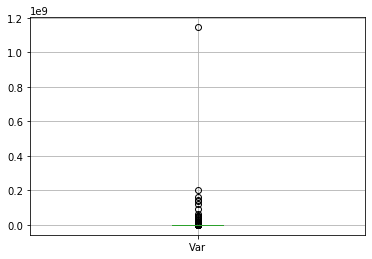

In [31]:
variance_table.boxplot()

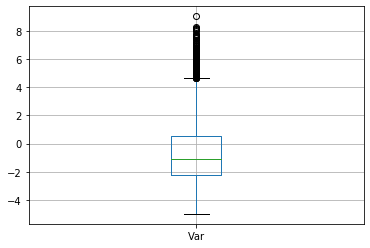

In [32]:
# e = 1e-3
# e = 1e-7
e = 1e-5
np.log10(variance_table + e).boxplot()

In [34]:
# len(variance_table[variance_table['Var'] > 1e5])
len(variance_table[variance_table['Var'] > 1e7])
# len(variance_table[variance_table['Var'] > 1e9])

23

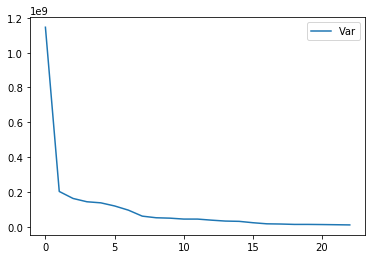

In [35]:
variance_table[variance_table['Var'] > 1e7].sort_values(by='Var', ascending=False).plot(use_index=False)

In [36]:
# Variance quantile to drop all genes but the top 2k
q = (variance_table.shape[0] - 2e3) / variance_table.shape[0]
print(f'Percentile = {round(q * 100, 1)}%')

variance_table[variance_table['Var'] > variance_table['Var'].quantile(q=q)].shape

Percentile = 96.7%


(2000, 1)

In [37]:
# Variance quantile to drop all genes but the top 1k
q = (variance_table.shape[0] - 1e3) / variance_table.shape[0]
print(f'Percentile = {round(q * 100, 1)}%')

variance_table[variance_table['Var'] > variance_table['Var'].quantile(q=q)].shape

Percentile = 98.4%


(1000, 1)

In [38]:
# Get IDs for all genes to keep
genes_to_keep = list(variance_table[variance_table['Var'] > variance_table['Var'].quantile(q=q)].index)
genes_to_keep[:5]

['ENSG00000000971.16',
 'ENSG00000002726.21',
 'ENSG00000002933.9',
 'ENSG00000004799.8',
 'ENSG00000005022.6']

In [39]:
len(genes_to_keep)

1000

## Load all data

In [40]:
def read_star_counts_tsv(path):
    df = pd.read_csv(path, sep='\t', header=1)
    df.drop(axis="index", labels=[0, 1, 2, 3], inplace=True) 
    '''
    #not data
    N_unmapped			1274782	1274782	1274782			
    N_multimapping			3451178	3451178	3451178			
    N_noFeature			3496697	24968184	25173810			
    N_ambiguous			4666983	1079397	1071109		
    '''
    df.reset_index(drop=True, inplace=True)
    return df

def load_all_mRNA_data(patient_file_map, genes):
    # n = len(patient_file_map)
    
    dfs = []
    for patient in tqdm(patient_file_map):
        # print('\r' + f'Load data tables: {str(i + 1)}/{n}', end='')
        # df = pd.read_csv(patient_file_map[patient], sep='\t', header=None,
        #                  index_col=0)
        # df = df.loc[genes]
        # df.columns = [patient]
        df = read_star_counts_tsv(patient_file_map[patient])
        df.set_index('gene_id', inplace=True)
        df = df[['fpkm_uq_unstranded']]
        df.columns = [patient]

        df = df.loc[genes]
        dfs.append(df)

    print()
    print()

    return dfs

In [41]:
%%time

data_tables = load_all_mRNA_data(patient_file_map=file_map, genes=genes_to_keep)

  0%|          | 0/4784 [00:00<?, ?it/s]

100%|██████████| 4784/4784 [09:19<00:00,  8.55it/s]



CPU times: user 7min 32s, sys: 56.9 s, total: 8min 29s
Wall time: 9min 19s


In [42]:
data_tables[0].head()

,TCGA-2F-A9KO
gene_id,
ENSG00000000971.16,30.8978
ENSG00000002726.21,0.8955
ENSG00000002933.9,11.0539
ENSG00000004799.8,18.2416
ENSG00000005022.6,241.7721


In [43]:
%%time

mRNA = merge_all_tables(data_tables)

Merge data tables: 264/4784

Merge data tables: 4784/4784
Final table dimensions: (1000, 4784)

CPU times: user 4min 15s, sys: 3.91 s, total: 4min 19s
Wall time: 4min 20s


## Scale values

In [44]:
mRNA.shape

(1000, 4784)

In [45]:
mRNA.head()

,TCGA-2F-A9KO,TCGA-2F-A9KP,TCGA-2F-A9KR,TCGA-2F-A9KW,TCGA-4Z-AA7M,TCGA-4Z-AA7N,TCGA-4Z-AA7O,TCGA-4Z-AA7Q,TCGA-4Z-AA7S,TCGA-4Z-AA7Y,TCGA-4Z-AA81,TCGA-4Z-AA82,TCGA-4Z-AA83,TCGA-4Z-AA84,TCGA-4Z-AA87,TCGA-4Z-AA89,TCGA-5N-A9KI,TCGA-5N-A9KM,TCGA-BL-A0C8,TCGA-BL-A13I,TCGA-BL-A13J,TCGA-BL-A5ZZ,TCGA-BT-A0S7,TCGA-BT-A20Q,TCGA-BT-A20R,TCGA-BT-A20T,TCGA-BT-A20U,TCGA-BT-A2LA,TCGA-BT-A2LB,TCGA-BT-A3PH,TCGA-BT-A3PJ,TCGA-BT-A42C,TCGA-BT-A42F,TCGA-C4-A0EZ,TCGA-C4-A0F0,TCGA-C4-A0F6,TCGA-CF-A1HS,TCGA-CF-A3MF,TCGA-CF-A3MI,TCGA-CF-A47S,TCGA-CF-A47T,TCGA-CF-A47V,TCGA-CF-A47W,TCGA-CF-A5U8,TCGA-CF-A5UA,TCGA-CF-A7I0,TCGA-CF-A8HX,TCGA-CF-A8HY,TCGA-CF-A9FF,TCGA-CF-A9FL,TCGA-CF-A9FM,TCGA-CU-A0YN,TCGA-CU-A0YO,TCGA-CU-A3KJ,TCGA-CU-A3YL,TCGA-CU-A5W6,TCGA-CU-A72E,TCGA-DK-A1A3,TCGA-DK-A1A7,TCGA-DK-A1AA,TCGA-DK-A1AB,TCGA-DK-A1AC,TCGA-DK-A1AD,TCGA-DK-A1AE,TCGA-DK-A1AF,TCGA-DK-A1AG,TCGA-DK-A2HX,TCGA-DK-A2I2,TCGA-DK-A2I6,TCGA-DK-A3IK,TCGA-DK-A3IL,TCGA-DK-A3IM,TCGA-DK-A3IN,TCGA-DK-A3IQ,TCGA-DK-A3IS,TCGA-DK-A3IT,TCGA-DK-A3IU,TCGA-DK-A3IV,TCGA-DK-A3WW,TCGA-DK-A3WX,TCGA-DK-A3WY,TCGA-DK-A3X1,TCGA-DK-A3X2,TCGA-DK-A6AV,TCGA-DK-A6B0,TCGA-DK-A6B1,TCGA-DK-A6B2,TCGA-DK-A6B5,TCGA-E5-A4TZ,TCGA-E5-A4U1,TCGA-E7-A3X6,TCGA-E7-A3Y1,TCGA-E7-A4IJ,TCGA-E7-A4XJ,TCGA-E7-A519,TCGA-E7-A541,TCGA-E7-A5KE,TCGA-E7-A5KF,TCGA-E7-A677,TCGA-E7-A678,TCGA-E7-A6MD,TCGA-E7-A6ME,TCGA-E7-A6MF,TCGA-E7-A7DU,TCGA-E7-A7DV,TCGA-E7-A7XN,TCGA-E7-A8O7,TCGA-E7-A97P,TCGA-FD-A3B3,TCGA-FD-A3B4,TCGA-FD-A3B5,TCGA-FD-A3B6,TCGA-FD-A3B7,TCGA-FD-A3B8,TCGA-FD-A3N5,TCGA-FD-A3N6,TCGA-FD-A3SL,TCGA-FD-A3SM,TCGA-FD-A3SN,TCGA-FD-A3SO,TCGA-FD-A3SP,TCGA-FD-A3SQ,TCGA-FD-A3SR,TCGA-FD-A3SS,TCGA-FD-A43N,TCGA-FD-A43U,TCGA-FD-A43X,TCGA-FD-A43Y,TCGA-FD-A5BR,TCGA-FD-A5BS,TCGA-FD-A5BT,TCGA-FD-A5BU,TCGA-FD-A5BV,TCGA-FD-A5BX,TCGA-FD-A5BY,TCGA-FD-A5BZ,TCGA-FD-A5C0,TCGA-FD-A5C1,TCGA-FD-A62N,TCGA-FD-A62O,TCGA-FD-A62P,TCGA-FD-A6TA,TCGA-FD-A6TB,TCGA-FD-A6TC,TCGA-FD-A6TD,TCGA-FD-A6TE,TCGA-FD-A6TG,TCGA-FD-A6TH,TCGA-FD-A6TI,TCGA-FD-A6TK,TCGA-FJ-A3Z7,TCGA-FJ-A3Z9,TCGA-FJ-A3ZF,TCGA-FT-A3EE,TCGA-G2-A2EF,TCGA-G2-A2EK,TCGA-G2-A2EO,TCGA-G2-A2ES,TCGA-G2-A3IB,TCGA-G2-A3VY,TCGA-G2-AA3B,TCGA-G2-AA3F,TCGA-GC-A3BM,TCGA-GC-A3I6,TCGA-GC-A3OO,TCGA-GC-A3RB,TCGA-GC-A3RC,TCGA-GC-A3RD,TCGA-GC-A3WC,TCGA-GC-A3YS,TCGA-GC-A4ZW,TCGA-GC-A6I1,TCGA-GD-A2C5,TCGA-GD-A3OQ,TCGA-GD-A6C6,TCGA-GU-A42P,TCGA-GU-A42Q,TCGA-GU-A42R,TCGA-GU-A762,TCGA-GU-A763,TCGA-GU-A764,TCGA-GU-A767,TCGA-GU-AATP,TCGA-GU-AATQ,TCGA-GV-A3JV,TCGA-GV-A3JX,TCGA-GV-A3QH,TCGA-GV-A3QI,TCGA-GV-A3QK,TCGA-GV-A40G,TCGA-GV-A6ZA,TCGA-H4-A2HO,TCGA-H4-A2HQ,TCGA-HQ-A2OE,TCGA-HQ-A2OF,TCGA-HQ-A5NE,TCGA-K4-A3WU,TCGA-K4-A3WV,TCGA-K4-A4AC,TCGA-K4-A54R,TCGA-K4-A5RJ,TCGA-K4-A6FZ,TCGA-K4-A6MB,TCGA-K4-A83P,TCGA-K4-AAQO,TCGA-LC-A66R,TCGA-LT-A5Z6,TCGA-LT-A8JT,TCGA-MV-A51V,TCGA-PQ-A6FI,TCGA-PQ-A6FN,TCGA-S5-A6DX,TCGA-S5-AA26,TCGA-SY-A9G0,TCGA-SY-A9G5,TCGA-UY-A78K,TCGA-UY-A78L,TCGA-UY-A78M,TCGA-UY-A78N,TCGA-UY-A78O,TCGA-UY-A78P,TCGA-UY-A8OB,TCGA-UY-A8OC,TCGA-UY-A8OD,TCGA-UY-A9PA,TCGA-UY-A9PB,TCGA-UY-A9PD,TCGA-UY-A9PE,TCGA-UY-A9PF,TCGA-UY-A9PH,TCGA-XF-A8HB,TCGA-XF-A8HC,TCGA-XF-A8HD,TCGA-XF-A8HE,TCGA-XF-A8HF,TCGA-XF-A8HG,TCGA-XF-A8HH,TCGA-XF-A9SH,TCGA-XF-A9SI,TCGA-XF-A9SK,TCGA-XF-A9SL,TCGA-XF-A9SP,TCGA-XF-A9ST,TCGA-XF-A9SU,TCGA-XF-A9SV,TCGA-XF-A9SW,TCGA-XF-A9SX,TCGA-XF-A9SY,TCGA-XF-A9SZ,TCGA-XF-A9T2,...,TCGA-BR-A4J7,TCGA-BR-A4J8,TCGA-BR-A4J9,TCGA-BR-A4PD,TCGA-BR-A4PE,TCGA-BR-A4PF,TCGA-BR-A4QL,TCGA-BR-A4QM,TCGA-CD-5798,TCGA-CD-5799,TCGA-CD-5800,TCGA-CD-5801,TCGA-CD-5803,TCGA-CD-5804,TCGA-CD-8524,TCGA-CD-8525,TCGA-CD-8526,TCGA-CD-8527,TCGA-CD-8528,TCGA-CD-8529,TCGA-CD-8532,TCGA-CD-8533,TCGA-CD-8534,TCGA-CD-8536,TCGA-CD-A486,TCGA-CD-A487,TCGA-CD-A489,TCGA-CD-A48A,TCGA-CD-A48C,TCGA-CD-A4MH,TCGA-CD-A4MI,TCGA-CD-A4MJ,TCGA-CG-4301,TCGA-CG-4305,TCGA-CG-4306,TCGA-CG-4436,TCGA-CG-4437,TCGA-CG-4438,TCGA-CG-4440,TCGA-CG-4441,TCGA-CG-4443,TCGA-CG-4444,TCGA-CG-4466,TCGA-CG-4469,TCGA-CG-4475,TCGA-CG-4477,TCGA-CG-5717,TCGA-CG-5718,TCGA-CG-5719,TCGA-CG-5720,TCGA-CG-5721,TCGA-CG-5722,TCGA-CG-5723,TCGA-CG-5724,TCGA-CG-5725,TCGA-CG-5732,TCGA-CG-5734,TCGA

In [46]:
mRNA = min_max_scale(data=mRNA.T, features=mRNA.T.columns, groups=id_groups)

In [47]:
mRNA.head()

gene_id,ENSG00000000971.16,ENSG00000002726.21,ENSG00000002933.9,ENSG00000004799.8,ENSG00000005022.6,ENSG00000005513.10,ENSG00000008517.18,ENSG00000008988.11,ENSG00000010278.15,ENSG00000011600.12,ENSG00000012223.13,ENSG00000018625.15,ENSG00000019582.15,ENSG00000021826.17,ENSG00000022267.19,ENSG00000025423.11,ENSG00000026025.16,ENSG00000030582.18,ENSG00000034510.6,ENSG00000041982.16,ENSG00000042493.16,ENSG00000044574.8,ENSG00000046653.15,ENSG00000047457.14,ENSG00000053438.11,ENSG00000055957.11,ENSG00000058085.15,ENSG00000063177.13,ENSG00000065618.21,ENSG00000065978.19,ENSG00000066405.13,ENSG00000067225.18,ENSG00000068697.7,ENSG00000069849.11,ENSG00000070756.17,ENSG00000071082.11,ENSG00000072506.13,ENSG00000074800.16,ENSG00000075618.18,ENSG00000075624.17,ENSG00000077009.13,ENSG00000077498.9,ENSG00000077942.19,ENSG00000078898.7,ENSG00000079215.14,ENSG00000080824.19,ENSG00000080910.13,ENSG00000081051.8,ENSG00000081277.13,ENSG00000083845.9,ENSG00000084207.18,ENSG00000084234.18,ENSG00000084674.15,ENSG00000085465.13,ENSG00000085733.16,ENSG00000086062.13,ENSG00000086548.9,ENSG00000087086.15,ENSG00000087245.13,ENSG00000087250.9,ENSG00000087460.27,ENSG00000089009.15,ENSG00000089157.16,ENSG00000089199.10,ENSG00000089220.5,ENSG00000090382.7,ENSG00000091513.16,ENSG00000091583.11,ENSG00000091704.10,ENSG00000092010.15,ENSG00000092820.18,ENSG00000092841.19,ENSG00000096006.12,ENSG00000096088.16,ENSG00000096384.20,ENSG00000096696.14,ENSG00000099194.6,ENSG00000099795.7,ENSG00000099937.11,ENSG00000099953.10,ENSG00000100097.12,ENSG00000100197.22,ENSG00000100219.16,ENSG00000100234.12,ENSG00000100292.18,ENSG00000100300.18,ENSG00000100316.16,ENSG00000100342.21,ENSG00000100345.22,ENSG00000100373.10,ENSG00000100427.16,ENSG00000100604.13,ENSG00000100867.15,ENSG00000100979.15,ENSG00000100985.7,ENSG00000101160.14,ENSG00000101182.15,ENSG00000101335.10,ENSG00000101439.9,ENSG00000101443.18,ENSG00000101856.10,ENSG00000102007.11,ENSG00000102109.9,ENSG00000102144.15,ENSG00000102265.12,ENSG00000102316.17,ENSG00000102575.13,ENSG00000102837.7,ENSG00000102854.16,ENSG00000103257.9,ENSG00000103363.15,ENSG00000103569.10,ENSG00000104112.9,ENSG00000104267.10,ENSG00000104341.17,ENSG00000104371.5,ENSG00000104419.17,ENSG00000104760.17,ENSG00000104879.5,ENSG00000104904.12,ENSG00000104979.9,ENSG00000105141.6,ENSG00000105193.9,ENSG00000105202.9,ENSG00000105223.20,ENSG00000105372.8,ENSG00000105388.16,ENSG00000105398.4,ENSG00000105427.10,ENSG00000105519.18,ENSG00000105640.13,ENSG00000105664.11,ENSG00000105668.7,ENSG00000105699.16,ENSG00000105701.16,ENSG00000105825.14,ENSG00000105894.12,ENSG00000105974.13,ENSG00000106153.13,ENSG00000106211.10,ENSG00000106278.12,ENSG00000106327.13,ENSG00000106366.9,ENSG00000106537.8,ENSG00000106538.10,ENSG00000106541.12,ENSG00000106565.18,ENSG00000106624.11,ENSG00000106927.12,ENSG00000107159.13,ENSG00000107165.13,ENSG00000107223.13,ENSG00000107438.9,ENSG00000107485.18,ENSG00000107796.13,ENSG00000108107.15,ENSG00000108298.12,ENSG00000108518.8,ENSG00000108551.5,ENSG00000108602.18,ENSG00000108679.13,ENSG00000108821.14,ENSG00000108828.16,ENSG00000108849.8,ENSG00000108953.17,ENSG00000109062.12,ENSG00000109072.14,ENSG00000109107.14,ENSG00000109472.14,ENSG00000109475.16,ENSG00000109846.9,ENSG00000109971.14,ENSG00000110092.4,ENSG00000110169.11,ENSG00000110195.14,ENSG00000110243.12,ENSG00000110244.7,ENSG00000110245.12,ENSG00000110375.3,ENSG00000110484.7,ENSG00000110492.15,ENSG00000110680.13,ENSG00000110700.7,ENSG00000110955.9,ENSG00000111057.11,ENSG00000111341.10,ENSG00000111348.9,ENSG00000111640.15,ENSG00000111669.15,ENSG00000112306.8,ENSG00000112378.12,ENSG00000113140.11,ENSG00000113600.11,ENSG00000113739.10,ENSG00000113889.14,ENSG00000113905.5,ENSG00000113924.12,ENSG00000114391.13,ENSG00000114638.8,ENSG00000114771.14,ENSG00000114942.14,ENSG00000115255.12,ENSG00000115263.15,ENSG00000115268.10,ENSG00000115386.6,ENSG00000115414.21,ENSG00000115457.10,ENSG00000115461.5,ENSG00000115758.13,ENSG00000115884.11,ENSG00000116133.13,ENSG00000117318.9,ENSG00000117394

In [48]:
mRNA.shape

(4784, 1000)

In [53]:
ids = id_groups["train"] + id_groups["test"]
mRNA = mRNA.loc[ids]
mRNA.shape

(568, 1000)

## Save to files

In [65]:
mRNA.to_csv(f'{DATA_LOCATION}/RNA-seq.tsv', sep='\t')

In [66]:
DATA_LOCATION

'/mnt/data/d.kornilov/TCGA/processed_mtcp_intersection_all/GBM_LGG'

In [67]:
%%time

if not os.path.exists(os.path.join(DATA_LOCATION, 'RNA-seq')):
    os.makedirs(os.path.join(DATA_LOCATION, 'RNA-seq'))

table_to_patient_files(
    mRNA, dir_path=os.path.join(DATA_LOCATION, 'RNA-seq'), round_digits=4)

Save data to files: 568/568

CPU times: user 2.97 s, sys: 58.4 ms, total: 3.03 s
Wall time: 3.04 s


# DNA methylation

As explained in the GDC [Methylation Liftover Pipeline page](https://docs.gdc.cancer.gov/Data/Bioinformatics_Pipelines/Methylation_LO_Pipeline/), data was generated using either Illumina Infinium Human Methylation 27 (HM27; 27'578 probes) or HumanMethylation450 (HM450; 485'577 probes).

Use the intersection of the probes between the two (25'978 probes).

## Map files to patients

Use the [GDC API](https://docs.gdc.cancer.gov/API/Users_Guide/Python_Examples/#using-python-to-query-the-gdc-api) to retrieve mapping between file names and patient IDs. Collect results as Pandas `DataFrame`.

In [75]:
%%time

DNAm_files = request_file_info(data_type='Methylation Array')
DNAm_files.shape

CPU times: user 84.7 ms, sys: 0 ns, total: 84.7 ms
Wall time: 6.81 s


(12359, 6)

In [76]:
DNAm_files.head()

,cases.0.samples.0.sample_type,cases.0.project.primary_site,file_name,cases.0.submitter_id,cases.0.project.project_id,id
0,Primary Tumor,Cervix,jhu-usc.edu_CESC.HumanMethylation450.10.lvl-3....,TCGA-FU-A40J,TCGA-CESC,6f8dd747-4c1b-4d4c-bc62-6b49cc66a1a1
1,Primary Tumor,Brain,jhu-usc.edu_GBM.HumanMethylation27.3.lvl-3.TCG...,TCGA-19-0963,TCGA-GBM,33b44cbe-1a1e-491f-ac93-4f5f70bc1005
2,Primary Tumor,Ovary,jhu-usc.edu_OV.HumanMethylation27.11.lvl-3.TCG...,TCGA-61-2008,TCGA-OV,c454a62d-7434-44e6-b42c-da54bc3778de
3,Primary Tumor,Lung,jhu-usc.edu_LUSC.HumanMethylation450.6.lvl-3.T...,TCGA-56-7582,TCGA-LUSC,07c1bbc9-919f-4fce-9237-e1f59eb2621c
4,Primary Tumor,Lung,jhu-usc.edu_LUSC.HumanMethylation450.7.lvl-3.T...,TCGA-52-7809,TCGA-LUSC,0b8e19d0-275a-494d-9fdb-04a2a736e66d


In [77]:
DNAm_files = DNAm_files[DNAm_files['cases.0.project.project_id'].str.startswith('TCGA')]
DNAm_files = DNAm_files[DNAm_files['file_name'].str.endswith('gdc_hg38.txt')]
DNAm_files = DNAm_files[DNAm_files['cases.0.samples.0.sample_type'] == 'Primary Tumor']
DNAm_files.shape

(10505, 6)

As for miRNA above, when there is more than one file for a single patient just keep the first one. Again, this decision may be revisited later, if deemed useful.

In [78]:
print('All rows:       ', DNAm_files.shape[0])
print('Unique patients:', DNAm_files['cases.0.submitter_id'].unique().shape[0])

All rows:        10505
Unique patients: 10413


In [79]:
DNAm_files = DNAm_files[~DNAm_files.duplicated(subset=['cases.0.submitter_id'], keep='first')]
DNAm_files.shape

(10413, 6)

In [80]:
file_map = make_patient_file_map(DNAm_files, base_dir='/mnt/dataA/TCGA/raw/Methylation/')

### Drop unused patients

Keep only patients present in label data.

In [81]:
len(file_map)

10413

In [82]:
labels = pd.read_csv('../data/labels.tsv', sep='\t')
len(labels['submitter_id'])

11081

In [83]:
file_map = {k: file_map[k] for k in file_map if k in list(labels['submitter_id'])}

In [84]:
len(file_map)

10257

## Pick probe subset

Check a small subset of 100 files to get an idea of the types of data and their proportions in the dataset.

In [85]:
%%time

# List number of probes per file
total_n_lines = []
i = 0

for patient in file_map:
    i += 1
    if i > 100:
        break
    if isinstance(file_map[patient], tuple):
        total_n_lines = [total_n_lines.append(len(list(pd.read_csv(
            f, sep='\t', index_col=0, usecols=['Composite Element REF', 'Beta_value']).index)))
                         for f in file_map[patient]]
    else:
        total_n_lines.append(len(list(pd.read_csv(
            file_map[patient], sep='\t', index_col=0,
            usecols=['Composite Element REF', 'Beta_value']).index)))

CPU times: user 1min 1s, sys: 4.33 s, total: 1min 6s
Wall time: 1min 44s


In [86]:
set(total_n_lines)

{27578, 485577}

In [94]:
element = 27578
total_n_lines.count(element)

9

In [95]:
element = 485577
total_n_lines.count(element)

91

In [96]:
eg_file = file_map[list(file_map.keys())[100]]
total_n_lines = len(list(pd.read_csv(
    eg_file, sep='\t', index_col=0, usecols=['Composite Element REF', 'Beta_value']).index))
total_n_lines

485577

In [ ]:
DNAm = pd.read_csv(eg_file, sep='\t', index_col=0, usecols=['Composite Element REF', 'Beta_value'])

In [98]:
DNAm.head()

,Beta_value
Composite Element REF,
cg00000029,0.110788
cg00000108,NaN
cg00000109,NaN
cg00000165,0.420771
cg00000236,0.920627


In [99]:
DNAm.shape

(485577, 1)

In [100]:
probes = list(DNAm.index)
probes[:5]

['cg00000029', 'cg00000108', 'cg00000109', 'cg00000165', 'cg00000236']

In [101]:
DNAm = pd.read_csv('/mnt/dataA/TCGA/raw/Methylation/0000c40e-9d45-4446-9dd9-a4676224d0ce/jhu-usc.edu_GBM.HumanMethylation450.7.lvl-3.TCGA-19-5955-01A-11D-1697-05.gdc_hg38.txt',
                   sep='\t', index_col=0, usecols=['Composite Element REF', 'Beta_value'])

In [102]:
DNAm.head()

,Beta_value
Composite Element REF,
cg00000029,0.358175
cg00000108,NaN
cg00000109,NaN
cg00000165,0.385791
cg00000236,0.864110


In [103]:
DNAm.shape

(485577, 1)

In [104]:
DNAm[DNAm.index == 'cg00000292']

,Beta_value
Composite Element REF,
cg00000292,0.644535


In [110]:
%%time

print('# Illumina Infinium Human Methylation 27 (HM27) probes found in HumanMethylation450 (HM450):')
print(sum([p in probes for p in list(DNAm.index)]))
print()

# Illumina Infinium Human Methylation 27 (HM27) probes found in HumanMethylation450 (HM450):
485577
CPU times: user 23min 30s, sys: 19.9 ms, total: 23min 30s
Wall time: 23min 30s


Use the intersection of the probe sets in the two technologies (25'978 according to the two example files used here).

In [111]:
probe_set = [p for p in list(DNAm.index) if p in probes]

In [112]:
len(probe_set)

485577

In [113]:
probe_set[:10]

['cg00000029',
 'cg00000108',
 'cg00000109',
 'cg00000165',
 'cg00000236',
 'cg00000289',
 'cg00000292',
 'cg00000321',
 'cg00000363',
 'cg00000622']

### Save to file

In [18]:
target_file = '../data/DNAm_probes.tsv'

In [19]:
pd.read_csv(target_file, sep='\t', header=None, names=['Probes']).head()

,Probes
0,cg00000292
1,cg00002426
2,cg00003994
3,cg00005847
4,cg00006414


In [21]:
pd.read_csv(target_file, sep='\t', header=None, names=['Probes']).shape

(25978, 1)

### Compute variance for all selected probes

Run dedicated script (found here in `src/scripts` directory) as follows:

```bash
$ conda activate ig
$ python ./compute_DNAm_variance.py \
   -i /mnt/dataA/TCGA/raw/Methylation/ \
   -s 5000 \
   -l ../data/labels.tsv \
   -p ../data/DNAm_probes.tsv \
   -o /mnt/dataA/TCGA/raw/DNA_methylation_Beta-value_variance.tsv
```

### Define probe subset

Keep a sensible number of probes showing the highest variance across patients.

In [117]:
# Load computed variance table
variance_table = pd.read_csv('/mnt/dataA/TCGA/raw/DNA_methylation_Beta-value_variance.tsv', sep='\t',
                             header=None, index_col=0, names=['Var'])

In [118]:
variance_table.head()

,Var
cg00000292,0.032868
cg00002426,0.048514
cg00003994,0.042728
cg00005847,0.062739
cg00006414,NaN


In [119]:
variance_table.sort_values('Var', ascending=False).head(10)

,Var
cg20916523,0.106645
cg12374721,0.106500
cg22881914,0.102368
cg15083233,0.097124
cg21790626,0.095604
cg02085507,0.095520
cg21359747,0.095092
cg04034767,0.094479
cg06051311,0.094403
cg03064067,0.094293


In [120]:
variance_table.describe()

,Var
count,23377.000000
mean,0.018027
std,0.020000
min,0.000008
25%,0.000650
50%,0.009537
75%,0.032214
max,0.106645


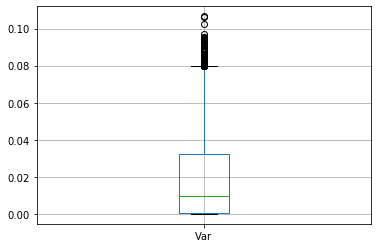

In [121]:
variance_table.boxplot()

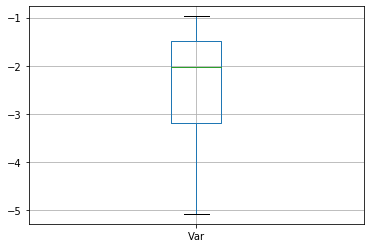

In [122]:
e = 1e-7
np.log10(variance_table + e).boxplot()

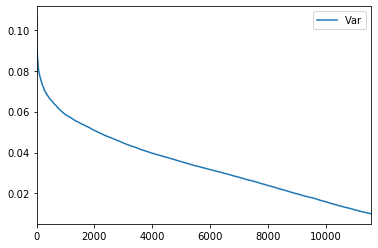

In [123]:
variance_table[variance_table['Var'] > 1e-2].sort_values(by='Var', ascending=False).plot(use_index=False)

In [124]:
# Variance quantile to drop all genes but the chosen number of probes showing the top variance
# (since there are quite a lot of missing values, the result is lower than the selected number of probes)
q = (variance_table.shape[0] - 4e3) / variance_table.shape[0]
print(f'Percentile = {round(q * 100, 1)}%')

variance_table[variance_table['Var'] > variance_table['Var'].quantile(q=q)].shape

Percentile = 84.6%


(3601, 1)

In [125]:
# Get IDs for all probes to keep
probes_to_keep = list(variance_table[variance_table['Var'] > variance_table['Var'].quantile(q=q)].index)
probes_to_keep[:5]

['cg00002426', 'cg00003994', 'cg00005847', 'cg00015770', 'cg00027083']

In [126]:
len(probes_to_keep)

3601

## Load all data

In [127]:
def load_all_DNAm_data(patient_file_map, probes):
    n = len(patient_file_map)
    
    dfs = []
    for i, patient in enumerate(patient_file_map):
        print('\r' + f'Load data tables: {str(i + 1)}/{n}', end='')
        df = pd.read_csv(patient_file_map[patient], sep='\t', index_col=0,
                         usecols=['Composite Element REF', 'Beta_value'])
        df = df.loc[probes]
        df.columns = [patient]
        dfs.append(df)

    print()
    print()

    return dfs

In [128]:
%%time

data_tables = load_all_DNAm_data(patient_file_map=file_map, probes=probes_to_keep)

Load data tables: 10257/10257

CPU times: user 1h 43min 11s, sys: 6min 21s, total: 1h 49min 33s
Wall time: 2h 54min 30s


In [129]:
data_tables[0].head()

,TCGA-FU-A40J
Composite Element REF,
cg00002426,0.318415
cg00003994,0.599392
cg00005847,0.672742
cg00015770,0.712197
cg00027083,0.593536


In [130]:
%%time

DNAm = merge_all_tables(data_tables)

Merge data tables: 10257/10257
Final table dimensions: (3601, 10257)

CPU times: user 24min 14s, sys: 3.37 s, total: 24min 17s
Wall time: 24min 43s


__Note:__ There is <font style="color:red">no need to scale DNA methylation Beta Values</font> here, since they are already in the interval [0, 1].

In [131]:
DNAm.shape

(3601, 10257)

In [132]:
DNAm.head()

,TCGA-FU-A40J,TCGA-19-0963,TCGA-61-2008,TCGA-56-7582,TCGA-52-7809,TCGA-NK-A5CT,TCGA-18-3409,TCGA-39-5030,TCGA-ET-A39P,TCGA-EL-A3ZM,...,TCGA-37-A5EN,TCGA-85-8355,TCGA-NC-A5HD,TCGA-B7-5816,TCGA-VS-A9U5,TCGA-HG-A2PA,TCGA-EX-A1H5,TCGA-ZX-AA5X,TCGA-AL-3473,TCGA-US-A774
Composite Element REF,,,,,,,,,,,,,,,,,,,,,
cg00002426,0.318415,0.046072,0.027547,0.415223,0.648575,0.621004,0.716911,0.707517,0.293981,0.931081,...,0.438482,0.747201,0.545356,0.462450,0.531422,0.442948,0.400525,0.487032,0.689412,0.471680
cg00003994,0.599392,0.016736,0.024404,0.302878,0.216912,0.049533,0.041870,0.314953,0.056696,0.212163,...,0.104503,0.116226,0.047025,0.301587,0.842026,0.346946,0.688067,0.498006,0.121292,0.097266
cg00005847,0.672742,0.564070,0.678181,0.801770,0.585623,0.496684,0.687045,0.482277,0.162784,0.467108,...,0.729212,0.517948,0.745251,0.730452,0.675245,0.639452,0.826099,0.536603,0.424725,0.260113
cg00015770,0.712197,0.377250,0.035846,0.677078,0.420451,0.544561,0.085075,0.344044,0.140085,0.098670,...,0.688385,0.223122,0.120548,0.481762,0.661487,0.103892,0.294951,0.483926,0.097199,0.261816
cg00027083,0.593536,0.612349,0.006701,0.042713,0.170042,0.571381,0.037359,0.228693,0.011983,0.011264,...,0.253170,0.254117,0.039685,0.468094,0.542668,0.497510,0.601865,0.478359,0.038121,0.448850


In [133]:
DNAm=DNAm.T

In [134]:
DNAm.head()

Composite Element REF,cg00002426,cg00003994,cg00005847,cg00015770,cg00027083,cg00030047,cg00041575,cg00061629,cg00075967,cg00077877,...,cg27566805,cg27603796,cg27619475,cg27631256,cg27631817,cg27637521,cg27644292,cg27650175,cg27652350,cg27653134
TCGA-FU-A40J,0.318415,0.599392,0.672742,0.712197,0.593536,0.492215,0.486741,0.239983,0.638742,0.644392,...,0.422796,0.078062,0.040128,0.770458,0.787100,0.046893,0.802030,0.027544,0.699939,0.451170
TCGA-19-0963,0.046072,0.016736,0.564070,0.377250,0.612349,0.115964,0.279452,0.175651,0.832125,0.297031,...,0.134330,0.012355,0.440111,0.331650,0.162716,0.562431,0.255868,0.007070,0.178792,0.533509
TCGA-61-2008,0.027547,0.024404,0.678181,0.035846,0.006701,0.958637,0.749230,0.984989,0.361550,0.677952,...,0.910393,0.023884,0.005834,0.897992,0.936422,0.006167,0.737140,0.006494,0.941924,0.729672
TCGA-56-7582,0.415223,0.302878,0.801770,0.677078,0.042713,0.754153,0.787535,0.862927,0.703165,0.779320,...,0.845062,0.062053,0.629369,0.756181,0.717296,0.045877,0.579433,0.031817,0.714729,0.368923
TCGA-52-7809,0.648575,0.216912,0.585623,0.420451,0.170042,0.701835,0.273324,0.802313,0.353930,0.459806,...,0.693101,0.213740,0.066981,0.670231,0.639546,0.053299,0.305550,0.032148,0.232483,0.670081


## Replace `nan` by median value

In [135]:
DNAm.isna().sum()

Composite Element REF
cg00002426    2
cg00003994    1
cg00005847    0
cg00015770    0
cg00027083    0
             ..
cg27637521    0
cg27644292    0
cg27650175    6
cg27652350    0
cg27653134    8
Length: 3601, dtype: int64

In [136]:
DNAm.median()

Composite Element REF
cg00002426    0.419640
cg00003994    0.100634
cg00005847    0.624895
cg00015770    0.219640
cg00027083    0.228034
                ...   
cg27637521    0.105601
cg27644292    0.543935
cg27650175    0.033792
cg27652350    0.470317
cg27653134    0.677752
Length: 3601, dtype: float64

In [137]:
DNAm.fillna(DNAm.median()).isna().sum()

Composite Element REF
cg00002426    0
cg00003994    0
cg00005847    0
cg00015770    0
cg00027083    0
             ..
cg27637521    0
cg27644292    0
cg27650175    0
cg27652350    0
cg27653134    0
Length: 3601, dtype: int64

In [138]:
DNAm = DNAm.fillna(DNAm.median())

## Save to files

# CNV

## Map aliquotes to patients

Use the [GDC API](https://docs.gdc.cancer.gov/API/Users_Guide/Python_Examples/#using-python-to-query-the-gdc-api) to retrieve mapping of aliquote IDs to patients found in the 33 tables (one per cancer entity). Collect results as Pandas `DataFrame`.

In [9]:
%%time

response = requests.get('https://api.gdc.cancer.gov/cases',
                        params={
                            'fields': 'cases.samples.portions.analytes.aliquots',
                            'format': 'TSV',
                            'size': '200000'
                        })
cnv_aliquotes = pd.read_csv(StringIO(response.content.decode("utf-8")), sep="\t")

<string>:2: DtypeWarning: Columns (3,4,5,6,7,8,9,10,11,12,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,58,59,60,61,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,128,135,136,137,138,139,140,141,145,146,148,149,151,152,153,154,155,156,157,158,160,161,162,164,165,166,169,170,171,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,202,203,205,206,207,208,209,210,211,212,213,214,215,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,270,271,272,273,274,275,276,277,281,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,

CPU times: user 4.55 s, sys: 493 ms, total: 5.04 s
Wall time: 1min 40s


In [10]:
cnv_aliquotes = cnv_aliquotes.set_index('submitter_id')
cnv_aliquotes.shape

(83709, 416)

In [11]:
cnv_aliquotes.head()

,submitter_sample_ids.3,submitter_sample_ids.2,submitter_aliquot_ids.39,submitter_aliquot_ids.38,submitter_aliquot_ids.37,submitter_aliquot_ids.36,submitter_aliquot_ids.35,submitter_aliquot_ids.34,submitter_aliquot_ids.33,submitter_aliquot_ids.32,...,aliquot_ids.7,aliquot_ids.6,aliquot_ids.5,aliquot_ids.4,aliquot_ids.3,aliquot_ids.2,aliquot_ids.1,aliquot_ids.0,submitter_sample_ids.9,submitter_sample_ids.8
submitter_id,,,,,,,,,,,,,,,,,,,,,
AD5099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,507b7397-e1c4-4cd6-a349-a16f38c74aa1,NaN,NaN
AD13897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90ff000a-9c08-4db1-8720-32c1f0dcadc6,NaN,NaN
AD6581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,d351e716-6fc2-4968-87df-069d3a063516,NaN,NaN
AD5120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,166f6598-1616-425d-af97-808fe0496327,NaN,NaN
AD15398,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75fb9395-6c42-414f-b53e-00da745a0c42,NaN,NaN


In [12]:
cnv_aliquotes = cnv_aliquotes[cnv_aliquotes.index.str.startswith('TCGA')]

In [13]:
print('Unique patients:', cnv_aliquotes.index.unique().shape[0])

Unique patients: 11315


In [14]:
cnv_aliquotes.index.duplicated

<bound method Index.duplicated of Index(['TCGA-CJ-4885', 'TCGA-AK-3444', 'TCGA-A3-3319', 'TCGA-J9-A8CM',
       'TCGA-HC-7075', 'TCGA-CH-5792', 'TCGA-KK-A8I9', 'TCGA-YL-A8HO',
       'TCGA-XK-AAJR', 'TCGA-EJ-A46F',
       ...
       'TCGA-AK-3426', 'TCGA-G6-A8L6', 'TCGA-A3-3363', 'TCGA-CJ-4916',
       'TCGA-B4-5377', 'TCGA-B8-5162', 'TCGA-XK-AAJP', 'TCGA-EJ-A7NG',
       'TCGA-KK-A6E0', 'TCGA-G9-6343'],
      dtype='object', name='submitter_id', length=11315)>

In [15]:
aliquote_map = {}

aliquote_cols = [col for col in cnv_aliquotes if col.startswith('aliquot_ids')]

for index, row in cnv_aliquotes.iterrows():
    if index in aliquote_map.keys():
        print(index, 'already in aliquote map!')
    
    aliquote_map[index] = []
    row = row.loc[~row.isnull()]
    cols = [col for col in aliquote_cols if col in row]
    
    for col in cols:
        aliquote_map[index].append(row[col])

In [16]:
len(aliquote_map)

11315

## Load all data

In [17]:
!ls /mnt/dataA/TCGA/raw/CNV/ | wc -l

33


In [18]:
def load_all_CNV_data():
    base_dir = '/mnt/dataA/TCGA/raw/CNV/'
    project_dirs = [(os.path.join(base_dir, d)) for d in os.listdir(base_dir)]
    files = [(os.path.join(pd, f)) for pd in project_dirs
             for f in os.listdir(pd) if f.endswith('focal_score_by_genes.txt')]    
    
    dfs = []
    n = len(files)

    for i, f in enumerate(files):
        print('\r' + f'Load data tables: {str(i + 1)}/{n}', end='')
        df = pd.read_csv(f, sep='\t', index_col=0)
        df = df.iloc[:, 2:]
        dfs.append(df)

    print()
    print()

    return dfs

In [19]:
data_tables = load_all_CNV_data()

Load data tables: 33/33



In [20]:
data_tables[0].head()

,6015d8f7-0d07-4f55-a354-599051125694,a4204b58-1517-4c97-bc8c-fefaf9273661,12a057c2-f889-444d-a746-781db933f815,48c9bdb7-111a-48da-8b2f-330bff1297a5,a2c1b942-386f-4067-bc48-b0f9b1337954,03586ea2-a637-4834-b9d3-a37d434ec85a,1997a8f1-93cc-4d1f-9620-71e7df5bc943,dc8d9cbb-c62c-4d8b-ac12-6a88794dfa78,fbffdae0-9068-4ca8-87d4-237b6e6ebf75,6c2e7546-d2f4-4929-a0b5-b5a5752447c9,...,1a8e93cb-79d8-4f05-a62d-5447f1e260bf,a336ae82-015e-4e75-ae8a-30eef59fc178,bf783afb-bd32-44c3-90e7-12a96f90aef2,5c213cbd-5bf3-4c85-be17-58ad899461ec,8ad26d9b-69be-46b5-a0ac-abbed06aec7c,5ae1c24a-b8cc-433d-80b5-a80cc09ee1c4,cfb3ff19-6ac1-4bbc-b32c-17b05117cbee,64ca1fc3-3a0a-4ef8-b98f-e1db5e3095e7,654e8e74-1b1f-49c1-a62f-8756c3252019,5c1d7b4c-7c3b-4d20-bb38-c4451313dc18
Gene Symbol,,,,,,,,,,,,,,,,,,,,,
ENSG00000008128.21,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,-1,0
ENSG00000008130.14,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,-1,0
ENSG00000067606.14,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,-1,0
ENSG00000078369.16,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,-1,0
ENSG00000078808.15,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,-1,0


In [21]:
cnv = merge_all_tables(data_tables)

Merge data tables: 33/33
Final table dimensions: (19729, 11368)



In [22]:
cnv.shape

(19729, 11368)

## Are there unchanged genes?

Any genes with the same value for all patients will be completely uninformative.

In [23]:
# Any genes with same CNV value across all samples?
unchanged_genes = []

for index, row in cnv.iterrows():
    if len(pd.unique(row)) < 2:
        unchanged_genes.append(index)

In [24]:
print('# of unchanged genes:', len(unchanged_genes))

# of unchanged genes: 0


## Replace aliquote by patient IDs

In [25]:
def lookup_submitter_id(df, aliquote_id_map):
    cols = df.columns
    n = len(cols)

    for i, col in enumerate(cols):
        print('\r' + f'Replace col names by patient IDs: {str(i + 1)}/{n}', end='')
        for patient in aliquote_id_map:
            if col in aliquote_id_map[patient]:
                patient_id = patient
            
        df.rename(columns={col: patient_id}, inplace=True)
   
    return df

In [26]:
%%time

cnv = lookup_submitter_id(cnv, aliquote_map)
print()

Replace col names by patient IDs: 11368/11368
CPU times: user 32min 54s, sys: 20min 1s, total: 52min 55s
Wall time: 52min 48s


In [27]:
cnv.head()

,TCGA-D9-A1JX,TCGA-FS-A1ZT,TCGA-FS-A1ZS,TCGA-FS-A1ZP,TCGA-FS-A1ZN,TCGA-FS-A1ZM,TCGA-FS-A1Z4,TCGA-FS-A1ZR,TCGA-FS-A1ZQ,TCGA-FS-A1ZK,...,TCGA-GS-A9TW,TCGA-FF-A7CR,TCGA-VB-A8QN,TCGA-FF-A7CX,TCGA-FA-A7DS,TCGA-GS-A9TQ,TCGA-FA-A7Q1,TCGA-FA-A82F,TCGA-GS-A9TT,TCGA-G8-6324
Gene Symbol,,,,,,,,,,,,,,,,,,,,,
ENSG00000008128.21,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,-1,0,0,0
ENSG00000008130.14,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,-1,0,0,0
ENSG00000067606.14,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,-1,0,0,0
ENSG00000078369.16,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,-1,0,0,0
ENSG00000078808.15,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,-1,0,0,0


### Check duplicate patient IDs

Are there duplicate column names (more than one aliquote from the same patient)? If so, keep only one after checking that all values are equal.

In [28]:
# Any non-replaced column names
old_names = []
for col in cnv.columns:
    if not col.startswith('TCGA-'):
        old_names.append(col)

print('# columns with old name (not replaced by patient ID):', len(old_names))

# columns with old name (not replaced by patient ID): 0


In [29]:
# Non-unique column names
len(cnv.columns) - len(set(cnv.columns))

348

In [30]:
from collections import Counter

c = Counter(cnv.columns)

duplicated_cols = [col for col in c if c[col] > 1]
len(duplicated_cols)

290

In [31]:
set(c.values())

{1, 2, 3, 4}

In [32]:
# Are repeats different?

not_equal_cols = []

for col in duplicated_cols:
    n_repeats = cnv.loc[:, col].shape[1]
    for i in range(n_repeats):
        if not cnv.loc[:, col].iloc[:, 0].equals(cnv.loc[:, col].iloc[:, 1]):
            not_equal_cols.append(col)

In [33]:
len(set(not_equal_cols))

284

In [34]:
not_equal_cols[:5]

['TCGA-ER-A2NF',
 'TCGA-ER-A2NF',
 'TCGA-ER-A19T',
 'TCGA-ER-A19T',
 'TCGA-V5-A7RC']

In [35]:
# How different are they? Look at a couple of examples
eg = cnv.loc[:, not_equal_cols[60]]
eg.head()

,TCGA-B2-5633,TCGA-B2-5633,TCGA-B2-5633
Gene Symbol,,,
ENSG00000008128.21,0,0,0
ENSG00000008130.14,0,0,0
ENSG00000067606.14,0,0,0
ENSG00000078369.16,0,0,0
ENSG00000078808.15,0,0,0


In [36]:
print('# equal rows:', len(np.where(eg.iloc[:, 0] == eg.iloc[:, 1])[0]))
print('# different rows:', len(np.where(eg.iloc[:, 0] != eg.iloc[:, 1])[0]))

# equal rows: 17985
# different rows: 1744


Variable number of differences. My non-systematic check returned values from as low as 5 different values to as high as 1'744. For now, just drop all but one column at random.

In [37]:
cnv = cnv.T
cnv.head()

Gene Symbol,ENSG00000008128.21,ENSG00000008130.14,ENSG00000067606.14,ENSG00000078369.16,ENSG00000078808.15,ENSG00000107404.16,ENSG00000116151.12,ENSG00000127054.17,ENSG00000131584.17,ENSG00000131591.16,...,ENSG00000268651.2,ENSG00000274183.1,ENSG00000274791.1,ENSG00000277150.1,ENSG00000277203.1,ENSG00000277745.1,ENSG00000277858.1,ENSG00000124333.13,ENSG00000124334.15,ENSG00000168939.9
TCGA-D9-A1JX,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-FS-A1ZT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-FS-A1ZS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-FS-A1ZP,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-FS-A1ZN,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
cnv.shape

(11368, 19729)

In [39]:
# Non-unique column names
cnv[cnv.index.duplicated()].shape

(348, 19729)

In [40]:
len(cnv)

11368

In [41]:
cnv = cnv.drop_duplicates(keep='first')
len(cnv)

11031

In [42]:
# Non-unique column names
cnv[cnv.index.duplicated()].shape

(330, 19729)

In [43]:
cnv_copy = cnv.copy()

In [44]:
cnv_copy.shape

(11031, 19729)

In [46]:
idxs = []
to_drop = []
n = cnv_copy.shape[0]

for i, idx in enumerate(cnv_copy.index):
    print('\r' + f'Check patient IDs for repeats: {str(i + 1)}/{n}', end='')
    if idx not in idxs:
        idxs.append(idx)
    else:
        to_drop.append(i)


Check patient IDs for repeats: 1/11031
Check patient IDs for repeats: 2/11031
Check patient IDs for repeats: 3/11031
Check patient IDs for repeats: 4/11031
Check patient IDs for repeats: 5/11031
Check patient IDs for repeats: 6/11031
Check patient IDs for repeats: 7/11031
Check patient IDs for repeats: 8/11031
Check patient IDs for repeats: 9/11031
Check patient IDs for repeats: 10/11031
Check patient IDs for repeats: 11/11031
Check patient IDs for repeats: 12/11031
Check patient IDs for repeats: 13/11031
Check patient IDs for repeats: 14/11031
Check patient IDs for repeats: 15/11031
Check patient IDs for repeats: 16/11031
Check patient IDs for repeats: 17/11031
Check patient IDs for repeats: 18/11031
Check patient IDs for repeats: 19/11031
Check patient IDs for repeats: 20/11031
Check patient IDs for repeats: 21/11031
Check patient IDs for repeats: 22/11031
Check patient IDs for repeats: 23/11031
Check patient IDs for repeats: 24/11031
Check patient IDs for repeats: 25/11031
Check pa


Check patient IDs for repeats: 3081/11031
Check patient IDs for repeats: 3082/11031
Check patient IDs for repeats: 3083/11031
Check patient IDs for repeats: 3084/11031
Check patient IDs for repeats: 3085/11031
Check patient IDs for repeats: 3086/11031
Check patient IDs for repeats: 3087/11031
Check patient IDs for repeats: 3088/11031
Check patient IDs for repeats: 3089/11031
Check patient IDs for repeats: 3090/11031
Check patient IDs for repeats: 3091/11031
Check patient IDs for repeats: 3092/11031
Check patient IDs for repeats: 3093/11031
Check patient IDs for repeats: 3094/11031
Check patient IDs for repeats: 3095/11031
Check patient IDs for repeats: 3096/11031
Check patient IDs for repeats: 3097/11031
Check patient IDs for repeats: 3098/11031
Check patient IDs for repeats: 3099/11031
Check patient IDs for repeats: 3100/11031
Check patient IDs for repeats: 3101/11031
Check patient IDs for repeats: 3102/11031
Check patient IDs for repeats: 3103/11031
Check patient IDs for repeats: 31


Check patient IDs for repeats: 5190/11031
Check patient IDs for repeats: 5191/11031
Check patient IDs for repeats: 5192/11031
Check patient IDs for repeats: 5193/11031
Check patient IDs for repeats: 5194/11031
Check patient IDs for repeats: 5195/11031
Check patient IDs for repeats: 5196/11031
Check patient IDs for repeats: 5197/11031
Check patient IDs for repeats: 5198/11031
Check patient IDs for repeats: 5199/11031
Check patient IDs for repeats: 5200/11031
Check patient IDs for repeats: 5201/11031
Check patient IDs for repeats: 5202/11031
Check patient IDs for repeats: 5203/11031
Check patient IDs for repeats: 5204/11031
Check patient IDs for repeats: 5205/11031
Check patient IDs for repeats: 5206/11031
Check patient IDs for repeats: 5207/11031
Check patient IDs for repeats: 5208/11031
Check patient IDs for repeats: 5209/11031
Check patient IDs for repeats: 5210/11031
Check patient IDs for repeats: 5211/11031
Check patient IDs for repeats: 5212/11031
Check patient IDs for repeats: 52


Check patient IDs for repeats: 6899/11031
Check patient IDs for repeats: 6900/11031
Check patient IDs for repeats: 6901/11031
Check patient IDs for repeats: 6902/11031
Check patient IDs for repeats: 6903/11031
Check patient IDs for repeats: 6904/11031
Check patient IDs for repeats: 6905/11031
Check patient IDs for repeats: 6906/11031
Check patient IDs for repeats: 6907/11031
Check patient IDs for repeats: 6908/11031
Check patient IDs for repeats: 6909/11031
Check patient IDs for repeats: 6910/11031
Check patient IDs for repeats: 6911/11031
Check patient IDs for repeats: 6912/11031
Check patient IDs for repeats: 6913/11031
Check patient IDs for repeats: 6914/11031
Check patient IDs for repeats: 6915/11031
Check patient IDs for repeats: 6916/11031
Check patient IDs for repeats: 6917/11031
Check patient IDs for repeats: 6918/11031
Check patient IDs for repeats: 6919/11031
Check patient IDs for repeats: 6920/11031
Check patient IDs for repeats: 6921/11031
Check patient IDs for repeats: 69


Check patient IDs for repeats: 8404/11031
Check patient IDs for repeats: 8405/11031
Check patient IDs for repeats: 8406/11031
Check patient IDs for repeats: 8407/11031
Check patient IDs for repeats: 8408/11031
Check patient IDs for repeats: 8409/11031
Check patient IDs for repeats: 8410/11031
Check patient IDs for repeats: 8411/11031
Check patient IDs for repeats: 8412/11031
Check patient IDs for repeats: 8413/11031
Check patient IDs for repeats: 8414/11031
Check patient IDs for repeats: 8415/11031
Check patient IDs for repeats: 8416/11031
Check patient IDs for repeats: 8417/11031
Check patient IDs for repeats: 8418/11031
Check patient IDs for repeats: 8419/11031
Check patient IDs for repeats: 8420/11031
Check patient IDs for repeats: 8421/11031
Check patient IDs for repeats: 8422/11031
Check patient IDs for repeats: 8423/11031
Check patient IDs for repeats: 8424/11031
Check patient IDs for repeats: 8425/11031
Check patient IDs for repeats: 8426/11031
Check patient IDs for repeats: 84


Check patient IDs for repeats: 9706/11031
Check patient IDs for repeats: 9707/11031
Check patient IDs for repeats: 9708/11031
Check patient IDs for repeats: 9709/11031
Check patient IDs for repeats: 9710/11031
Check patient IDs for repeats: 9711/11031
Check patient IDs for repeats: 9712/11031
Check patient IDs for repeats: 9713/11031
Check patient IDs for repeats: 9714/11031
Check patient IDs for repeats: 9715/11031
Check patient IDs for repeats: 9716/11031
Check patient IDs for repeats: 9717/11031
Check patient IDs for repeats: 9718/11031
Check patient IDs for repeats: 9719/11031
Check patient IDs for repeats: 9720/11031
Check patient IDs for repeats: 9721/11031
Check patient IDs for repeats: 9722/11031
Check patient IDs for repeats: 9723/11031
Check patient IDs for repeats: 9724/11031
Check patient IDs for repeats: 9725/11031
Check patient IDs for repeats: 9726/11031
Check patient IDs for repeats: 9727/11031
Check patient IDs for repeats: 9728/11031
Check patient IDs for repeats: 97


Check patient IDs for repeats: 10893/11031
Check patient IDs for repeats: 10894/11031
Check patient IDs for repeats: 10895/11031
Check patient IDs for repeats: 10896/11031
Check patient IDs for repeats: 10897/11031
Check patient IDs for repeats: 10898/11031
Check patient IDs for repeats: 10899/11031
Check patient IDs for repeats: 10900/11031
Check patient IDs for repeats: 10901/11031
Check patient IDs for repeats: 10902/11031
Check patient IDs for repeats: 10903/11031
Check patient IDs for repeats: 10904/11031
Check patient IDs for repeats: 10905/11031
Check patient IDs for repeats: 10906/11031
Check patient IDs for repeats: 10907/11031
Check patient IDs for repeats: 10908/11031
Check patient IDs for repeats: 10909/11031
Check patient IDs for repeats: 10910/11031
Check patient IDs for repeats: 10911/11031
Check patient IDs for repeats: 10912/11031
Check patient IDs for repeats: 10913/11031
Check patient IDs for repeats: 10914/11031
Check patient IDs for repeats: 10915/11031
Check pati

In [47]:
len(to_drop)

330

In [48]:
cnv.drop(cnv.index[to_drop], inplace=True)

In [49]:
cnv_copy.shape

(11031, 19729)

In [50]:
cnv.shape

(10428, 19729)

## Encode categorical variables

Encode values (0, 1, or -1) to use with categorical embeddings.

In [51]:
cnv.head()

Gene Symbol,ENSG00000008128.21,ENSG00000008130.14,ENSG00000067606.14,ENSG00000078369.16,ENSG00000078808.15,ENSG00000107404.16,ENSG00000116151.12,ENSG00000127054.17,ENSG00000131584.17,ENSG00000131591.16,...,ENSG00000268651.2,ENSG00000274183.1,ENSG00000274791.1,ENSG00000277150.1,ENSG00000277203.1,ENSG00000277745.1,ENSG00000277858.1,ENSG00000124333.13,ENSG00000124334.15,ENSG00000168939.9
TCGA-D9-A1JX,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-FS-A1ZT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-FS-A1ZS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-FS-A1ZP,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-FS-A1ZN,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
label_encoders = {}
for gene in cnv.columns:
    label_encoders[gene] = LabelEncoder()
    label_encoders[gene].fit_transform(cnv.loc[:, gene])

for gene in cnv.columns:
    cnv.loc[:, gene] = label_encoders[gene].fit_transform(cnv.loc[:, gene])

In [58]:
pd.unique(cnv.iloc[:, 0])

array([1, 2, 0])

In [59]:
pd.unique([int(cnv[col].nunique()) for col in cnv.columns])

array([3])

All genes have embedding dimension 3. According to the rule-of-thumb from the Fast.ai course the embedding size should be 2.

In [60]:
cat_dim = 3
emb_size = min(50, (cat_dim + 1) // 2)
print(f'Embedding size of {emb_size}')
print(f'(categorical dimension {cat_dim} and a total of {cnv.shape[1]} features)')

Embedding size of 2
(categorical dimension 3 and a total of 19729 features)


### Drop unused patients

Keep only patients present in label data.

In [61]:
labels = pd.read_csv('../data/labels.tsv', sep='\t')
len(labels['submitter_id'])

11081

In [62]:
cnv.shape

(10428, 19729)

In [63]:
len(cnv.index)

10428

In [64]:
%%time

for patient in cnv.index:
    if patient not in list(labels['submitter_id']):
        cnv.drop(patient, inplace=True)

CPU times: user 16.6 s, sys: 12.5 s, total: 29.1 s
Wall time: 29.2 s


In [65]:
cnv.shape

(10325, 19729)

## Keep only high-variance genes

In [66]:
var = cnv.var()

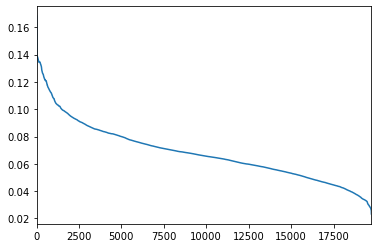

In [67]:
var[var > 1e-2].sort_values(ascending=False).plot(use_index=False)

In [68]:
# Variance quantile to drop all but the chosen number of genes showing the top variance
q = (len(var) - 5e3) / len(var)
print(f'Percentile = {round(q * 100, 1)}%')

var[var > var.quantile(q=q)].shape

Percentile = 74.7%


(5000,)

In [69]:
# Variance quantile to drop all but the chosen number of genes showing the top variance
q = (len(var) - 2e3) / len(var)
print(f'Percentile = {round(q * 100, 1)}%')

var[var > var.quantile(q=q)].shape

Percentile = 89.9%


(2000,)

In [70]:
# Get IDs for all genes to keep
genes_to_keep = list(var[var > var.quantile(q=q)].index)
genes_to_keep[:5]

['ENSG00000008128.21',
 'ENSG00000008130.14',
 'ENSG00000067606.14',
 'ENSG00000078369.16',
 'ENSG00000078808.15']

In [71]:
len(genes_to_keep)

2000

In [72]:
cnv = cnv[genes_to_keep]

In [73]:
cnv.shape

(10325, 2000)

## Save to files

# Watermark <a class='tocSkip'></a>

In [12]:
%watermark --iversions
%watermark -v
print()
%watermark -u -n

requests 2.22.0
numpy    1.18.1
pandas   1.0.1

CPython 3.6.7
IPython 7.11.1

last updated: Tue Jul 28 2020


[Top of the page](#Top)